Total files: 4320
Training files: 2160
Testing files: 2160
X_train shape: (237817, 57)
y_train shape: (237817, 54)
X_test shape:  (237969, 57)
y_test shape:  (237969, 54)


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5946/5946 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.1655 - loss: 6.0604 - val_accuracy: 0.4136 - val_loss: 3.0121 - learning_rate: 1.0000e-04
Epoch 2/100
5946/5946 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.3265 - loss: 3.1565 - val_accuracy: 0.4270 - val_loss: 2.0834 - learning_rate: 1.0000e-04
Epoch 3/100
5946/5946 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.3635 - loss: 2.3499 - val_accuracy: 0.4371 - val_loss: 1.8130 - learning_rate: 1.0000e-04
Epoch 4/100
5946/5946 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.3813 - loss: 2.0826 - val_accuracy: 0.4372 - val_loss: 1.7113 - learning_rate: 1.0000e-04
Epoch 5/100
5946/5946 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.3914 - loss: 1.9576 - val_accuracy: 0.4446 - val_loss: 1.6598 - learning_rate: 1.0000e-04
Epoch 6/100
5946/5946 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.3999 - loss: 1.9055 - val_accuracy: 0.4492 - val_loss: 1.6367 - learning_rate: 1.0000e-04
Epoch 7/100
5946/5946 ━━━━━━━━━━━━━━━━━━


Top-K Accuracy Results:
Top-1 Accuracy: 47.72%
Top-3 Accuracy: 77.97%
Top-5 Accuracy: 88.90%

✅ Model and scaler saved successfully.


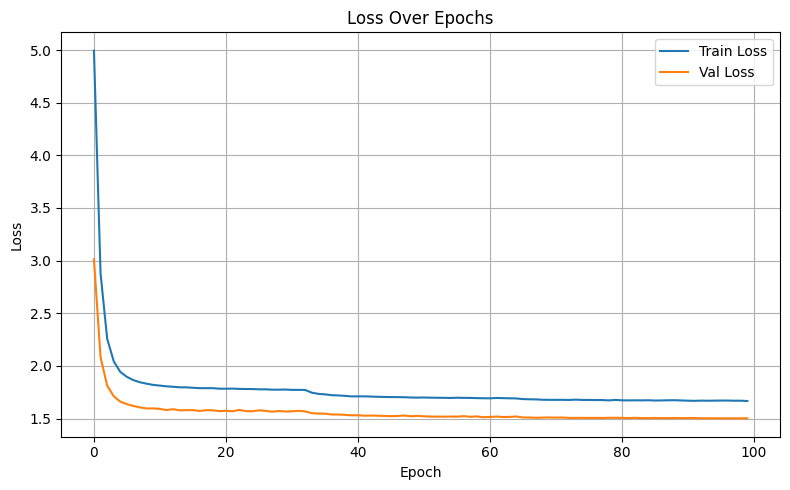

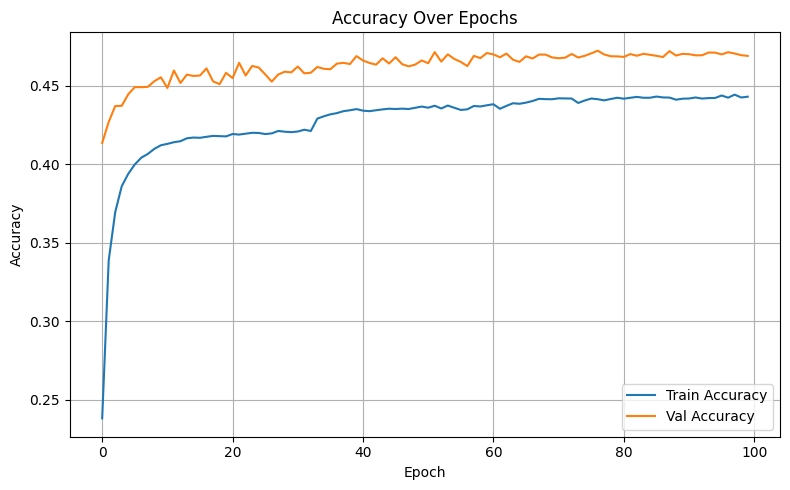

In [3]:
import os
import numpy as np
import pandas as pd
import ast
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle

# ================================
# File Utilities
# ================================
def generate_time_file_names(start_time_str, end_time_str, folder_path, prefix='optimal_file_data_'):
    start_time = datetime.strptime(start_time_str, '%H_%M_%S')
    end_time = datetime.strptime(end_time_str, '%H_%M_%S')
    current_time = start_time
    while current_time <= end_time:
        time_str = current_time.strftime('%H_%M_%S')
        file_name = f"{prefix}{time_str}.csv"
        yield os.path.join(folder_path, file_name)
        current_time += timedelta(seconds=20)

def load_data(file_names):
    data_list = []
    for file_name in file_names:
        if os.path.exists(file_name):
            df = pd.read_csv(file_name, usecols=[
                'feed_sat', 'Latitude', 'Longitude', 'Altitude',
                'visible_gateway_matrix', 'optimal_gateway_matrix'
            ])
            df.drop_duplicates(subset=['feed_sat'], inplace=True)
            df.dropna(inplace=True)
            data_list.append(df)
    return pd.concat(data_list, ignore_index=True) if data_list else None

def parse_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(matrix_str), dtype=np.float32)
    except:
        return None

# ================================
# Load Files
# ================================
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Final folder real data"

# Grab all CSVs in folder
all_files = sorted([
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith('.csv')
])

# Use 50% for training, 50% for testing
split_index = len(all_files) // 2
train_files = all_files[:split_index]
test_files = all_files[split_index:]

print(f"Total files: {len(all_files)}")
print(f"Training files: {len(train_files)}")
print(f"Testing files: {len(test_files)}")


train_data = load_data(train_files)
test_data = load_data(test_files)

# ================================
# Parse Gateway Matrices
# ================================
train_data['visible_gateway_matrix'] = train_data['visible_gateway_matrix'].apply(parse_matrix)
train_data['optimal_gateway_matrix'] = train_data['optimal_gateway_matrix'].apply(parse_matrix)
test_data['visible_gateway_matrix'] = test_data['visible_gateway_matrix'].apply(parse_matrix)
test_data['optimal_gateway_matrix'] = test_data['optimal_gateway_matrix'].apply(parse_matrix)

# Drop rows with parsing issues
train_data.dropna(subset=['visible_gateway_matrix', 'optimal_gateway_matrix'], inplace=True)
test_data.dropna(subset=['visible_gateway_matrix', 'optimal_gateway_matrix'], inplace=True)

# ================================
# Feature and Target Extraction
# ================================
# Combine position + visible gateway matrix
X_train_pos = train_data[['Latitude', 'Longitude', 'Altitude']].values
X_test_pos = test_data[['Latitude', 'Longitude', 'Altitude']].values

X_train_visible = np.vstack(train_data['visible_gateway_matrix'].values)
X_test_visible = np.vstack(test_data['visible_gateway_matrix'].values)

X_train = np.hstack([X_train_pos, X_train_visible])
X_test = np.hstack([X_test_pos, X_test_visible])

y_train = np.vstack(train_data['optimal_gateway_matrix'].values)
y_test = np.vstack(test_data['optimal_gateway_matrix'].values)

num_gateways = y_train.shape[1]

# ================================
# Normalize Features
# ================================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test_scaled.shape}")
print(f"y_test shape:  {y_test.shape}")

# ================================
# Build Model
# ================================
input_dim = X_train_scaled.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_gateways, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

# ================================
# Train Model
# ================================
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_reducer],
    verbose=1
)

# ================================
# Evaluate
# ================================
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\nTraining Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")
print(f"Test Loss:     {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# ================================
# Top-k Accuracy
# ================================
def compute_top_k_accuracy(model, X, y, k_values=[1, 3, 5]):
    preds = model.predict(X)
    y_true = np.argmax(y, axis=1)
    top_k = {k: np.argsort(preds, axis=1)[:, -k:] for k in k_values}
    return {
        k: np.mean([y_true[i] in top_k[k][i] for i in range(len(y_true))]) * 100
        for k in k_values
    }

top_k = compute_top_k_accuracy(model, X_test_scaled, y_test)
print("\nTop-K Accuracy Results:")
for k, acc in top_k.items():
    print(f"Top-{k} Accuracy: {acc:.2f}%")

# ================================
# Save Model & Scaler
# ================================
model.save('stage_1_model.h5')
with open('stage_1_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\n✅ Model and scaler saved successfully.")

import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
